In [4]:
import pandas as pd
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='ticks', context='paper')
from collections import defaultdict
import numpy as np
from util import plot_cdf

In [5]:
P99_PERCENTILE_LIST = np.arange(1, 101, 1)
MTU=1000
BDP = 10 * MTU
bin_size_list=[MTU, BDP, 5 * BDP]
labels = {0: '0<size<=MTU', 1:'MTU<size<=BDP', 2:'BDP<size<=5BDP', 3:'5BDP<size'}

n_size_bucket_list_output=len(bin_size_list)+1
n_percentiles=len(P99_PERCENTILE_LIST)

In [6]:
N_FLOW_THRESHOLD=1
NR_PATHS_SAMPLED=500
NR_INTEPOLATE=100
N_FLOWS=NR_PATHS_SAMPLED*NR_INTEPOLATE*4
shard_seed=1
mlsys_dir_list=["mlsys_e426_s1"]
legend_list=['ns3-config','pmn-m',"mlsys"]
res=[]
for mlsys_dir_idx,mlsys_dir in enumerate(mlsys_dir_list):
    save_file=f'./config_gen_{mlsys_dir}_p{NR_PATHS_SAMPLED}_l{NR_INTEPOLATE}_t{N_FLOW_THRESHOLD}.npz'
    if not os.path.exists(save_file):
        res_final=[]
        n_flows_in_f_list_final=[]
        for worst_low_id in range(192):
            mix_dir = f'../data/{worst_low_id}'
            if not os.path.exists(f'{mix_dir}/{legend_list[0]}/elapsed_{shard_seed}.txt'):
                print(f'{worst_low_id}: No GT!')
                res_final.append(np.zeros((n_size_bucket_list_output+1,2)))
                n_flows_in_f_list_final.append(np.zeros(NR_PATHS_SAMPLED))
                continue
            
            res_tmp=[]
            df_pmn_m = pd.read_csv(f'{mix_dir}/{legend_list[1]}/records.csv')
            
            n_freq_list=[]
            n_flows_in_f_list=[]
            n_flow_list=[]
            sizes_pmn=df_pmn_m['size']
            
            path_idx=0
            while os.path.exists(f'{mix_dir}/{mlsys_dir}/path_{path_idx}.txt'):
                with open(f'{mix_dir}/{mlsys_dir}/path_{path_idx}.txt', 'r') as file:
                    lines = file.readlines()
                    data=lines[0].strip().split(",")
                    n_freq=int(data[-1])
                    n_freq_list.append(n_freq)
                    for _ in range(n_freq):
                        n_flows_in_f_list.append(int(data[-3]))
                    
                    flowid_list=[int(tmp) for tmp in lines[2].strip().split(",")]
                    size_list=[sizes_pmn[flowid] for flowid in flowid_list]
                    
                    n_links=len(data[0].split("|"))-1
                    tmp=np.digitize(size_list, bin_size_list)
                    # Count occurrences of each bin index
                    bin_counts = np.zeros(n_size_bucket_list_output)
                    for bin_idx in tmp:
                        bin_counts[bin_idx]+=1
                    n_flow_list.append(bin_counts)
                path_idx+=1
            assert sum(n_freq_list)==NR_PATHS_SAMPLED
            n_flow_list=np.array(n_flow_list)
            n_flow_list_sum=n_flow_list.sum(axis=0)
            
            n_flows_in_f_list_final.append(n_flows_in_f_list)
            
            df_ns3 = pd.read_csv(f'{mix_dir}/{legend_list[0]}/records_{shard_seed}.csv')
            
            df_mlsys = [[] for _ in range(n_size_bucket_list_output)]
            
            sizes_ns3=np.array(df_ns3['size'])
            bin_ns3=np.digitize(sizes_ns3, bin_size_list)
            bin_counts = np.bincount(bin_ns3)
            total_count = np.sum(bin_counts)
            bucket_ratios = bin_counts / total_count
            
            with open(f'{mix_dir}/{mlsys_dir}/path.txt', 'r') as file:
                lines = file.readlines()
            lines = lines[1:]
            for line_idx,line in enumerate(lines):
                data=line.strip().split(",")
                data = [float(value) for value in data]
                assert len(data) == NR_INTEPOLATE
                n_freq=n_freq_list[line_idx//n_size_bucket_list_output]
                
                if n_flow_list[line_idx//n_size_bucket_list_output][line_idx%n_size_bucket_list_output]>=N_FLOW_THRESHOLD:
                    for _ in range(n_freq):
                        df_mlsys[line_idx%n_size_bucket_list_output].extend(data)
                
            df_mlsys_shape=[len(df_mlsys[i]) for i in range(len(df_mlsys))]
            print(f"{worst_low_id}: {df_mlsys_shape}, {np.max(n_freq_list)}")
            print("bucket_ratios: ",bucket_ratios)
            bucket_ratios_sampled=n_flow_list_sum/sum(n_flow_list_sum)
            print("bucket_ratios_sampled: ",bucket_ratios_sampled)
            
            sldn_mlsys_p99=np.array([np.percentile(df_mlsys[i],99) for i in range(len(df_mlsys))])
            
            print("df_mlsys_p99: ",sldn_mlsys_p99)
            df_mlsys_total=[]
            for i in range(len(df_mlsys)):
                n_tmp=int(N_FLOWS*bucket_ratios_sampled[i])
                df_mlsys_total.extend(np.random.choice(df_mlsys[i],n_tmp,replace=True))
            sldn_mlsys_p99=np.percentile(df_mlsys_total,99)

            sldn_ns3=df_ns3['slowdown']
            sldn_ns3_p99=np.percentile(sldn_ns3,99)
            
            print("sldn_ns3: ",sldn_ns3_p99," sldn_mlsys: ", sldn_mlsys_p99)

            res_tmp.append([sldn_ns3_p99,sldn_mlsys_p99])
            
            for i in range(len(bin_size_list)+1):
                tmp_sldn_ns3 = np.extract(bin_ns3==i, sldn_ns3)
                tmp_sldn_mlsys=df_mlsys[i]
                
                sldn_ns3_p99=np.percentile(tmp_sldn_ns3,99)
                df_mlsys_p99=np.percentile(tmp_sldn_mlsys,99)
                res_tmp.append([sldn_ns3_p99,df_mlsys_p99])
            res_final.append(res_tmp)
        res_final = np.array(res_final)
        n_flows_in_f_list_final = np.array(n_flows_in_f_list_final)
        print("res:", res_final.shape,n_flows_in_f_list_final.shape)
        np.savez(save_file,res_final=res_final,n_flows_in_f_list_final=n_flows_in_f_list_final)
    else:
        data=np.load(save_file)
        res_final=data['res_final']
        n_flows_in_f_list_final=data['n_flows_in_f_list_final']
    if mlsys_dir_idx==0:
        res.append(res_final[:,0,0].transpose())
        res.append(res_final[:,0,1].transpose())
    else:
        res.append(res_final[:,0,-1].transpose())
res=np.array(res)

mix_file = '../spec/all_counterfactual.mix.json'
with open(mix_file) as f:
    mixes = json.load(f) 
mask=[]
cc_dict={
    "dctcp":"dctcp",
    "timely": "timely_vwin",
    "dcqcn": "dcqcn_paper_vwin",
    "hp": "hp",
}
for mix in mixes:
    config_id=mix['id']
    cc=mix['cc']
    if not os.path.exists(f"../data/{config_id}/ns3-config/{shard_seed}/flows.txt") and not os.path.exists(f"../data/{config_id}/ns3-config/{shard_seed}/fct_topology_flows_{cc_dict[cc]}.txt"):
        mask.append(True)
    else:
        mask.append(False)
mask=np.array(mask)
res=res[:,mask]
n_flows_in_f_list_final=n_flows_in_f_list_final[mask]
print(res.shape)
n_flows_median_list=np.median(n_flows_in_f_list_final,axis=1)
print("n_flows_median_list: ",n_flows_median_list.shape)

(2, 189)
n_flows_median_list:  (189,)


median error:  [0.08052132]
90% error:  [0.23195195]
max error:  [0.6132301]
(1, 189)
(189,)
(2, 189)


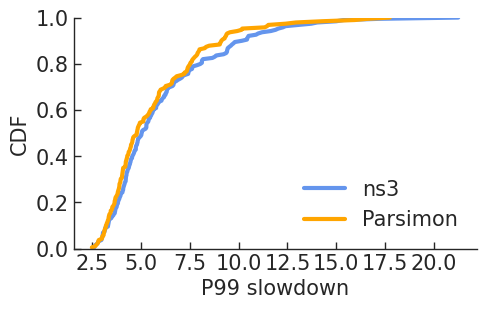

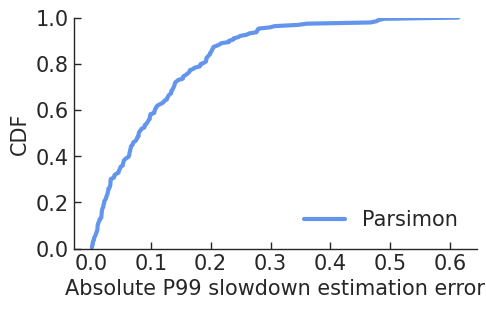

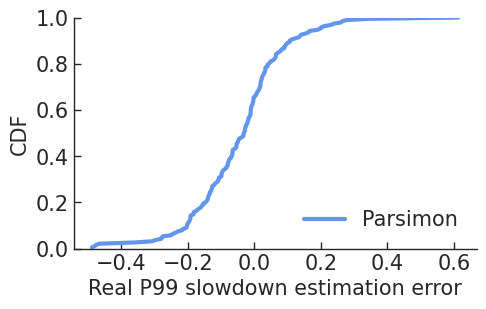

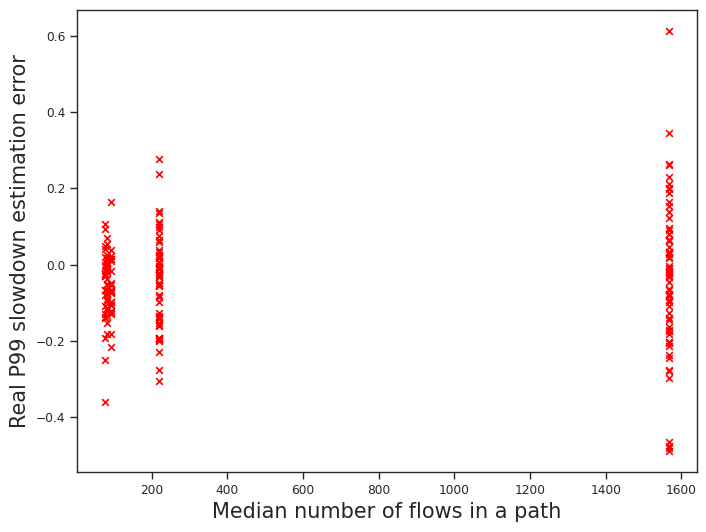

min: 158--0.4891142872442432, max: 12-0.6132301038723622


In [7]:
legend_list=['ns3',"Parsimon","m3"]
plot_cdf(res,None,legend_list,'P99 slowdown',legend_font=15,group_size=len(res),loc=4,rotate_xaxis=False)
error_abs=[]
for i in range(1,len(res)):
    tmp=np.abs(res[i]-res[0])/res[0]
    error_abs.append(tmp)
plot_cdf(error_abs,None,[legend_list[i] for i in range(1,len(legend_list))],'Absolute P99 slowdown estimation error',legend_font=15,group_size=len(error_abs),loc=4,rotate_xaxis=False)
print("median error: ", np.median(error_abs,axis=1))
print("90% error: ", np.percentile(error_abs,axis=1, q=90))
print("max error: ", np.max(error_abs,axis=1))

error_real=[]
for i in range(1,len(res)):
    error_real.append((res[i]-res[0])/res[0])
plot_cdf(error_real,None,[legend_list[i] for i in range(1,len(legend_list))],'Real P99 slowdown estimation error',legend_font=15,group_size=len(error_real),loc=4,rotate_xaxis=False) 


figure, ax = plt.subplots(figsize=(8, 6))
_fontsize=15
error_real=np.array(error_real)
print(error_real.shape)
print(n_flows_median_list.shape)
new_data=np.array([error_real[-1],n_flows_median_list])
print(new_data.shape)
plt.scatter(n_flows_median_list,error_real[-1],marker='x',color='red')
plt.xlabel('Median number of flows in a path', fontsize=_fontsize)
plt.ylabel('Real P99 slowdown estimation error', fontsize=_fontsize)
plt.show()

min_idx=np.argmin(error_real[-1])
max_idx=np.argmax(error_real[-1])
print(f"min: {min_idx}-{error_real[-1][min_idx]}, max: {max_idx}-{error_real[-1][max_idx]}")


In [8]:
mix_file = '../spec/all_counterfactual.mix.json'
with open(mix_file) as f:
    mixes = json.load(f) 
mask=[]
for mix in mixes:
    config_id=mix['id']
    cc=mix['cc']
    if not os.path.exists(f"../data/{config_id}/ns3-config/{shard_seed}/flows.txt") and not os.path.exists(f"../data/{config_id}/ns3-config/{shard_seed}/fct_topology_flows_{cc_dict[cc]}.txt"):
        mask.append(True)
    else:
        mask.append(False)
mask=np.array(mask)

mlsys_dir_list=["mlsys_e426_s1_p500_l100_t1"]
legend_list=['ns3',"mlsys"]
res=[]
for mlsys_dir_idx,mlsys_dir in enumerate(mlsys_dir_list):
    save_file=f'./config_gen_{mlsys_dir}.npz'
    data=np.load(save_file)
    tmp=data['res_final']
    n_flows_in_f_list_final=data['n_flows_in_f_list_final']
    val=tmp[:,0,:].transpose() 
    res.append(val[0])
    res.append(val[1])
res=np.array(res)
print(res.shape)
window_dict={
    0: "window: 05-14KB",
    1: "window: 14-23KB",
    2: "window: 23-30KB",
}
bfsz_dict={
    0: "buffer: 200-300KB",
    1: "buffer: 300-400KB",
    2: "buffer: 400-500KB",
}
dctcp_k_dict={
    0: "k: 05-9KB",
    1: "k: 09-13KB",
    2: "k: 13-17KB",
    3: "k: 17-20KB",
}
timely_tmin_dict={
    0: "tmin: 40-45us",
    1: "tmin: 45-50us",
    2: "tmin: 50-55us",
    3: "tmin: 55-60us",
}
timely_tmax_dict={
    0: "tmax: 100-113us",
    1: "tmax: 113-126us",
    2: "tmax: 126-139us",
    3: "tmax: 139-150us",
}
hp_ai_dict={
    0: "ai: 0500-625mbps",
    1: "ai: 0625-750mbps",
    2: "ai: 0750-875mbps",
    3: "ai: 875-1000mbps",
}
hp_ita_dict={
    0: "ita: 0.7-0.77",
    1: "ita: 0.77-0.84",
    2: "ita: 0.84-0.91",
    3: "ita: 0.91-0.95",
}
dcqcn_kmin_dict={
    0: "kmin: 20-28KB",
    1: "kmin: 28-36KB",
    2: "kmin: 36-44KB",
    3: "kmin: 44-50KB",
}
dcqcn_kmax_dict={
    0: "kmax: 50-63KB",
    1: "kmax: 63-76KB",
    2: "kmax: 76-89KB",
    3: "kmax: 89-100KB",
}
cc_legend_dict={
    "dctcp": "DCTCP",
    "timely": "TIMELY",
    "dcqcn": "DCQCN",
    "hp": "HPCC",
}

(2, 192)


/tmp/ipykernel_1747162/2980758117.py:27: RuntimeWarning: invalid value encountered in divide
  error_abs.append(np.abs(res[i]-res[0])/res[0])


len:  [52, 46, 46, 30]
median error:  [0.042395761561331874, 0.08903947202213547, 0.08010636111617334, 0.1385242107938142]
90% error:  [0.19722618059285157, 0.20290353924303073, 0.16818260647605657, 0.27823561454907747]
max error:  [0.26409362338038966, 0.24953837109390947, 0.3600468246206708, 0.6132301038723622]


/tmp/ipykernel_1747162/2980758117.py:43: RuntimeWarning: invalid value encountered in divide
  error_real.append((res[i]-res[0])/res[0])


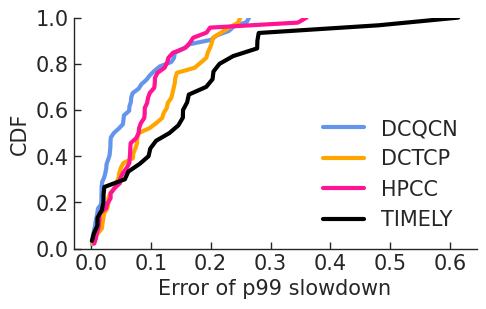

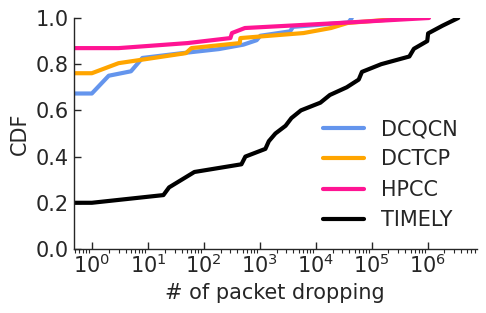

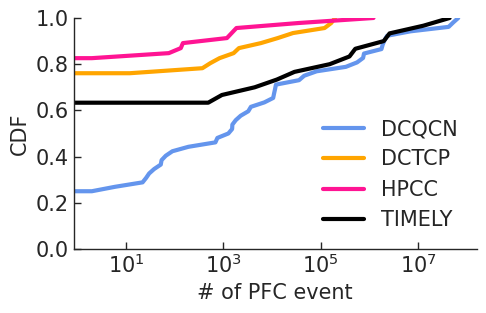

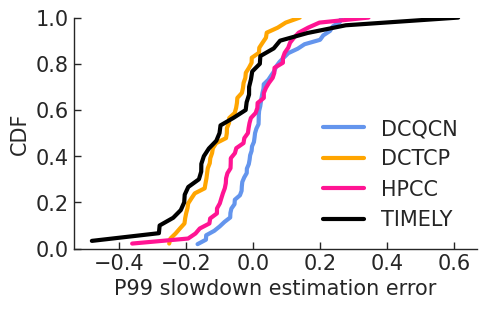

In [9]:

traffic_dict=defaultdict(list)
n_events_dict=defaultdict(list)
for mix_id in range(len(mixes)):
    if mask[mix_id]==False:
        continue
    mix=mixes[mix_id]
    cc=mix['cc']
    if mix["cc"]=="timely" and float(mix["param_1"])>60: continue
    val_key=cc_legend_dict[mix["cc"]]
    
    lines_pkt_dropping=0
    with open(f"../data/{mix_id}/ns3-config/1/output.txt", 'r') as file:
        for line in file:
            if "Headroom full" in line:
                lines_pkt_dropping+=1
    lines_pfc=[1]
    with open(f"../data/{mix_id}/ns3-config/1/pfc_topology_flows_{cc_dict[cc]}.txt", 'r') as file:
        lines_pfc = file.readlines()
        
    traffic_dict[val_key].append(mix_id)
    n_events_dict[val_key].append([lines_pkt_dropping,len(lines_pfc)])
traffic_dict = dict(sorted(traffic_dict.items()))
n_events_dict = dict(sorted(n_events_dict.items()))

error_abs=[]
for i in range(1,len(res)):
    error_abs.append(np.abs(res[i]-res[0])/res[0])
plot_data=[np.array([error_abs[0][i] for i in traffic_dict[key]]) for key in traffic_dict]
plot_cdf(plot_data,'figs/counterfactual_cdf_cc.pdf',list(traffic_dict.keys()),'Error of p99 slowdown',legend_font=15,group_size=len(traffic_dict),loc=4,rotate_xaxis=False)
print("len: ", [len(plot_data[i]) for i in range(len(plot_data))])
print("median error: ", [np.median(plot_data[i]) for i in range(len(plot_data))])
print("90% error: ", [np.percentile(plot_data[i],90) for i in range(len(plot_data))])
print("max error: ", [np.max(plot_data[i]) for i in range(len(plot_data))])

plot_data=[np.array([x[0] for x in n_events_dict[key]])  for key in n_events_dict]
plot_cdf(plot_data,None,list(n_events_dict.keys()),'# of packet dropping',legend_font=15,group_size=len(n_events_dict),loc=4,rotate_xaxis=False,log_switch=True)

plot_data=[np.array([x[1] for x in n_events_dict[key]])  for key in n_events_dict]
plot_cdf(plot_data,None,list(n_events_dict.keys()),'# of PFC event',legend_font=15,group_size=len(n_events_dict),loc=4,rotate_xaxis=False,log_switch=True)

error_real=[]
for i in range(1,len(res)):
    error_real.append((res[i]-res[0])/res[0])
plot_data=[np.array([error_real[0][i] for i in traffic_dict[key]]) for key in traffic_dict]
plot_cdf(plot_data,None,list(traffic_dict.keys()),'P99 slowdown estimation error',legend_font=15,group_size=len(traffic_dict),loc=4,rotate_xaxis=False)

/tmp/ipykernel_1333236/3384445147.py:29: RuntimeWarning: invalid value encountered in divide
  error_abs.append(np.abs(res[i]-res[0])/res[0])


len:  [85, 89]
median error:  [0.07976125194428581, 0.0702468001710995]
90% error:  [0.2295189782528006, 0.1989814652865335]
max error:  [0.6132301038723622, 0.3600468246206708]


/tmp/ipykernel_1333236/3384445147.py:45: RuntimeWarning: invalid value encountered in divide
  error_real.append((res[i]-res[0])/res[0])


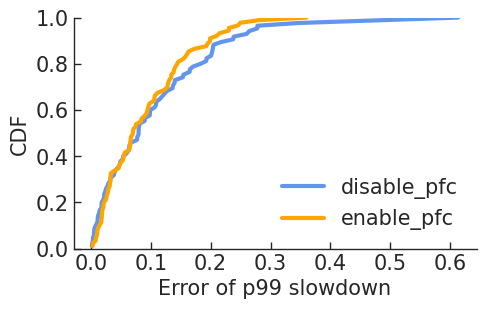

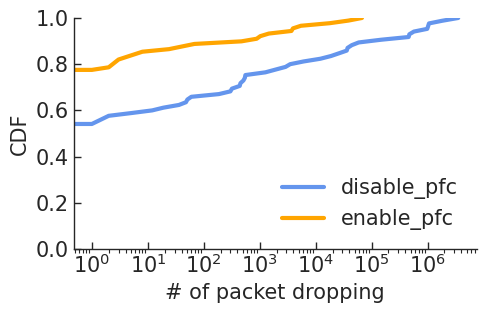

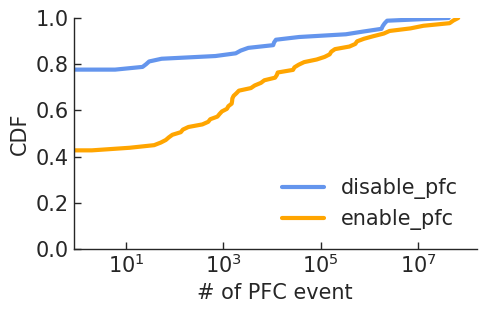

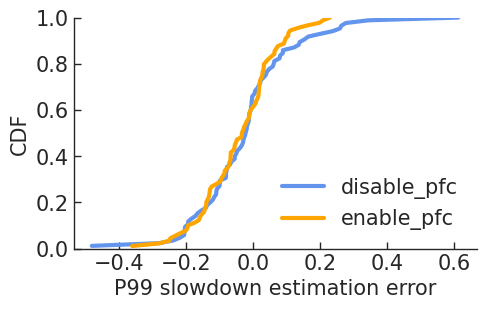

In [30]:

traffic_dict=defaultdict(list)
n_events_dict=defaultdict(list)
for mix_id in range(len(mixes)):
    if mask[mix_id]==False:
        continue
    mix=mixes[mix_id]
    cc=mix['cc']
    if mix["cc"]=="timely" and float(mix["param_1"])>60: continue
    val_key=cc_legend_dict[mix["cc"]]
    val_key="enable_pfc" if float(mix["enable_pfc"])==1.0 else "disable_pfc"
    
    # traffic_dict[traffic_mat+'_'+oversub].append(mix_id)
    lines_pkt_dropping=0
    with open(f"../data/{mix_id}/ns3-config/1/output.txt", 'r') as file:
        for line in file:
            if "Headroom full" in line:
                lines_pkt_dropping+=1
    lines_pfc=[1]
    with open(f"../data/{mix_id}/ns3-config/1/pfc_topology_flows_{cc_dict[cc]}.txt", 'r') as file:
        lines_pfc = file.readlines()
        
    traffic_dict[val_key].append(mix_id)
    n_events_dict[val_key].append([lines_pkt_dropping,len(lines_pfc)])
traffic_dict = dict(sorted(traffic_dict.items()))
n_events_dict = dict(sorted(n_events_dict.items()))

error_abs=[]
for i in range(1,len(res)):
    error_abs.append(np.abs(res[i]-res[0])/res[0])
plot_data=[np.array([error_abs[0][i] for i in traffic_dict[key]]) for key in traffic_dict]
plot_cdf(plot_data,'figs/counterfactual_cdf_pfc.pdf',list(traffic_dict.keys()),'Error of p99 slowdown',legend_font=15,group_size=len(traffic_dict),loc=4,rotate_xaxis=False)
print("len: ", [len(plot_data[i]) for i in range(len(plot_data))])
print("median error: ", [np.median(plot_data[i]) for i in range(len(plot_data))])
print("90% error: ", [np.percentile(plot_data[i],90) for i in range(len(plot_data))])
print("max error: ", [np.max(plot_data[i]) for i in range(len(plot_data))])

plot_data=[np.array([x[0] for x in n_events_dict[key]])  for key in n_events_dict]
plot_cdf(plot_data,None,list(n_events_dict.keys()),'# of packet dropping',legend_font=15,group_size=len(n_events_dict),loc=4,rotate_xaxis=False,log_switch=True)

plot_data=[np.array([x[1] for x in n_events_dict[key]])  for key in n_events_dict]
plot_cdf(plot_data,None,list(n_events_dict.keys()),'# of PFC event',legend_font=15,group_size=len(n_events_dict),loc=4,rotate_xaxis=False,log_switch=True)

error_real=[]
for i in range(1,len(res)):
    error_real.append((res[i]-res[0])/res[0])
plot_data=[np.array([error_real[0][i] for i in traffic_dict[key]]) for key in traffic_dict]
plot_cdf(plot_data,None,list(traffic_dict.keys()),'P99 slowdown estimation error',legend_font=15,group_size=len(traffic_dict),loc=4,rotate_xaxis=False)

/tmp/ipykernel_1333236/3326924714.py:27: RuntimeWarning: invalid value encountered in divide
  error_abs.append(np.abs(res[i]-res[0])/res[0])


len:  [61, 59, 54]
median error:  [0.07574698480608974, 0.07976125194428581, 0.06784727184131803]
90% error:  [0.21488445045455645, 0.20601355011622707, 0.19898425485048835]
max error:  [0.6132301038723622, 0.3600468246206708, 0.4803326018714933]


/tmp/ipykernel_1333236/3326924714.py:43: RuntimeWarning: invalid value encountered in divide
  error_real.append((res[i]-res[0])/res[0])


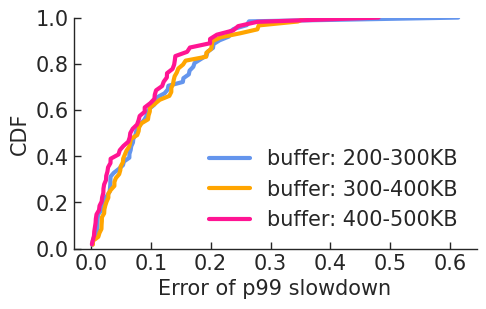

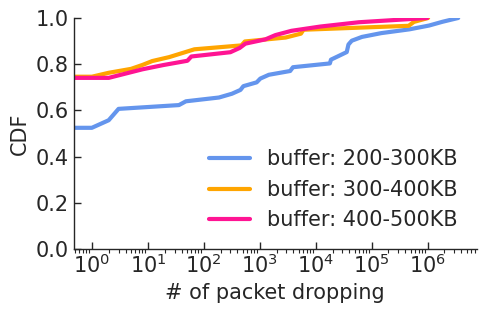

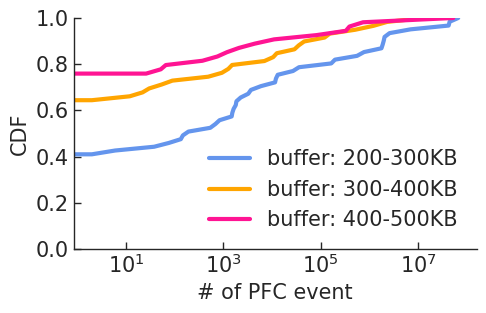

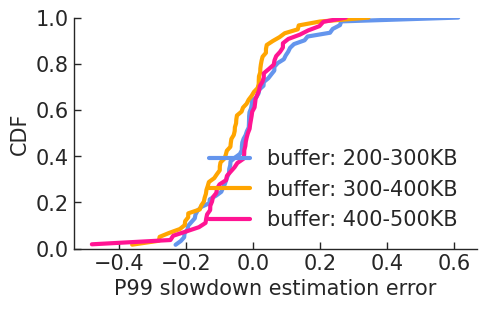

In [31]:

traffic_dict=defaultdict(list)
n_events_dict=defaultdict(list)
for mix_id in range(len(mixes)):
    if mask[mix_id]==False:
        continue
    mix=mixes[mix_id]
    cc=mix['cc']
    if mix["cc"]=="timely" and float(mix["param_1"])>60: continue
    val_key=cc_legend_dict[mix["cc"]]
    val_key=bfsz_dict[(mix["bfsz"]-20)//10]
    lines_pkt_dropping=0
    with open(f"../data/{mix_id}/ns3-config/1/output.txt", 'r') as file:
        for line in file:
            if "Headroom full" in line:
                lines_pkt_dropping+=1
    lines_pfc=[1]
    with open(f"../data/{mix_id}/ns3-config/1/pfc_topology_flows_{cc_dict[cc]}.txt", 'r') as file:
        lines_pfc = file.readlines()
        
    traffic_dict[val_key].append(mix_id)
    n_events_dict[val_key].append([lines_pkt_dropping,len(lines_pfc)])
traffic_dict = dict(sorted(traffic_dict.items()))
n_events_dict = dict(sorted(n_events_dict.items()))

error_abs=[]
for i in range(1,len(res)):
    error_abs.append(np.abs(res[i]-res[0])/res[0])
plot_data=[np.array([error_abs[0][i] for i in traffic_dict[key]]) for key in traffic_dict]
plot_cdf(plot_data,'figs/counterfactual_cdf_bfsz.pdf',list(traffic_dict.keys()),'Error of p99 slowdown',legend_font=15,group_size=len(traffic_dict),loc=4,rotate_xaxis=False)
print("len: ", [len(plot_data[i]) for i in range(len(plot_data))])
print("median error: ", [np.median(plot_data[i]) for i in range(len(plot_data))])
print("90% error: ", [np.percentile(plot_data[i],90) for i in range(len(plot_data))])
print("max error: ", [np.max(plot_data[i]) for i in range(len(plot_data))])

plot_data=[np.array([x[0] for x in n_events_dict[key]])  for key in n_events_dict]
plot_cdf(plot_data,None,list(n_events_dict.keys()),'# of packet dropping',legend_font=15,group_size=len(n_events_dict),loc=4,rotate_xaxis=False,log_switch=True)

plot_data=[np.array([x[1] for x in n_events_dict[key]])  for key in n_events_dict]
plot_cdf(plot_data,None,list(n_events_dict.keys()),'# of PFC event',legend_font=15,group_size=len(n_events_dict),loc=4,rotate_xaxis=False,log_switch=True)

error_real=[]
for i in range(1,len(res)):
    error_real.append((res[i]-res[0])/res[0])
plot_data=[np.array([error_real[0][i] for i in traffic_dict[key]]) for key in traffic_dict]
plot_cdf(plot_data,None,list(traffic_dict.keys()),'P99 slowdown estimation error',legend_font=15,group_size=len(traffic_dict),loc=4,rotate_xaxis=False)

/tmp/ipykernel_1333236/3121695398.py:28: RuntimeWarning: invalid value encountered in divide
  error_abs.append(np.abs(res[i]-res[0])/res[0])


median error:  [0.08357143850036022, 0.07976125194428581, 0.05464776464413174]
90% error:  [0.21062574520825803, 0.18777453937529395, 0.21956700727103148]
max error:  [0.4803326018714933, 0.2802201794261001, 0.6132301038723622]


/tmp/ipykernel_1333236/3121695398.py:43: RuntimeWarning: invalid value encountered in divide
  error_real.append((res[i]-res[0])/res[0])


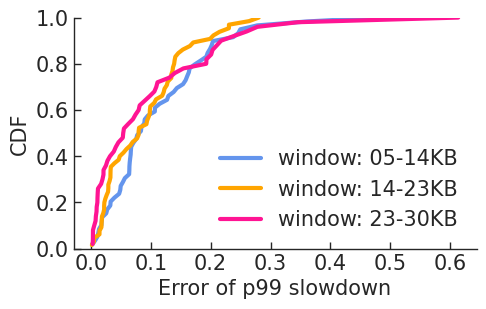

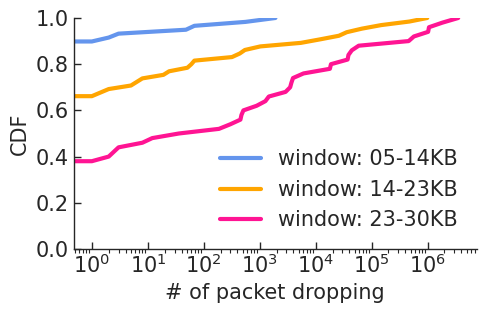

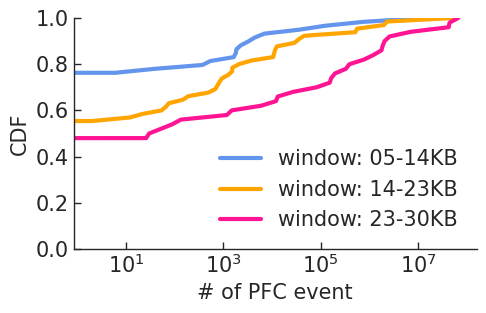

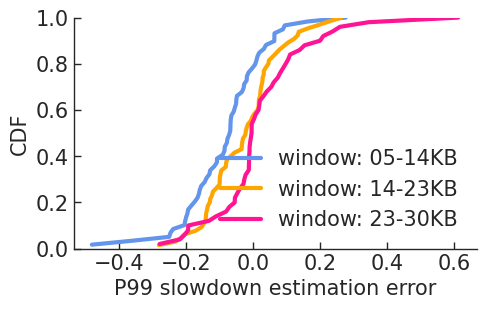

In [32]:

traffic_dict=defaultdict(list)
n_events_dict=defaultdict(list)
for mix_id in range(len(mixes)):
    if mask[mix_id]==False:
        continue
    mix=mixes[mix_id]
    cc=mix['cc']
    if mix["cc"]=="timely" and float(mix["param_1"])>60: continue
    val_key=cc_legend_dict[mix["cc"]]
    val_key=window_dict[(mix["window"]-5000)//9000]
    
    lines_pkt_dropping=0
    with open(f"../data/{mix_id}/ns3-config/1/output.txt", 'r') as file:
        for line in file:
            if "Headroom full" in line:
                lines_pkt_dropping+=1
    lines_pfc=[1]
    with open(f"../data/{mix_id}/ns3-config/1/pfc_topology_flows_{cc_dict[cc]}.txt", 'r') as file:
        lines_pfc = file.readlines()
        
    traffic_dict[val_key].append(mix_id)
    n_events_dict[val_key].append([lines_pkt_dropping,len(lines_pfc)])
traffic_dict = dict(sorted(traffic_dict.items()))
n_events_dict = dict(sorted(n_events_dict.items()))

error_abs=[]
for i in range(1,len(res)):
    error_abs.append(np.abs(res[i]-res[0])/res[0])
plot_data=[np.array([error_abs[0][i] for i in traffic_dict[key]]) for key in traffic_dict]
plot_cdf(plot_data,'figs/counterfactual_cdf_window.pdf',list(traffic_dict.keys()),'Error of p99 slowdown',legend_font=15,group_size=len(traffic_dict),loc=4,rotate_xaxis=False)
print("median error: ", [np.median(plot_data[i]) for i in range(len(plot_data))])
print("90% error: ", [np.percentile(plot_data[i],90) for i in range(len(plot_data))])
print("max error: ", [np.max(plot_data[i]) for i in range(len(plot_data))])

plot_data=[np.array([x[0] for x in n_events_dict[key]])  for key in n_events_dict]
plot_cdf(plot_data,None,list(n_events_dict.keys()),'# of packet dropping',legend_font=15,group_size=len(n_events_dict),loc=4,rotate_xaxis=False,log_switch=True)

plot_data=[np.array([x[1] for x in n_events_dict[key]])  for key in n_events_dict]
plot_cdf(plot_data,None,list(n_events_dict.keys()),'# of PFC event',legend_font=15,group_size=len(n_events_dict),loc=4,rotate_xaxis=False,log_switch=True)

error_real=[]
for i in range(1,len(res)):
    error_real.append((res[i]-res[0])/res[0])
plot_data=[np.array([error_real[0][i] for i in traffic_dict[key]]) for key in traffic_dict]
plot_cdf(plot_data,None,list(traffic_dict.keys()),'P99 slowdown estimation error',legend_font=15,group_size=len(traffic_dict),loc=4,rotate_xaxis=False)

/tmp/ipykernel_1333236/508417603.py:35: RuntimeWarning: invalid value encountered in divide
  error_abs.append(np.abs(res[i]-res[0])/res[0])


median error:  [0.047863325967124046, 0.04330496493172361, 0.13135679788929788, 0.21067986024089708]
90% error:  [0.1853993549571766, 0.11458302230885087, 0.19383742546700528, 0.24698896283511484]
max error:  [0.19898592858886127, 0.13823619033721912, 0.2019134550701004, 0.24953837109390947]


/tmp/ipykernel_1333236/508417603.py:50: RuntimeWarning: invalid value encountered in divide
  error_real.append((res[i]-res[0])/res[0])


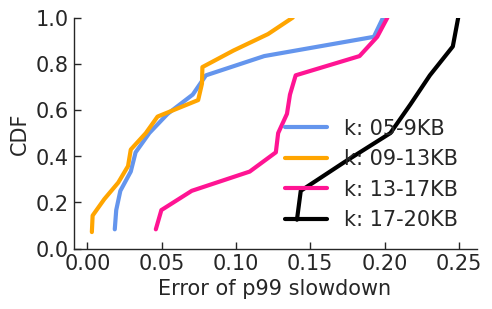

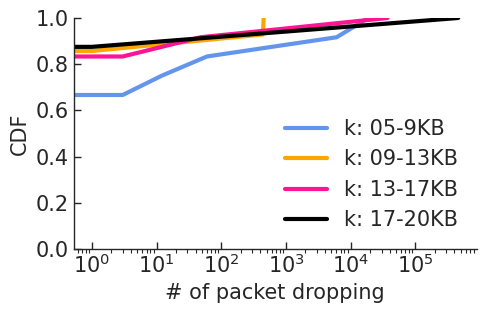

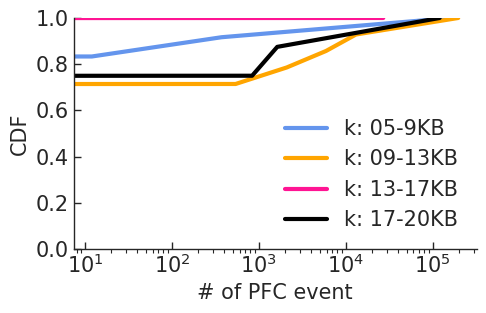

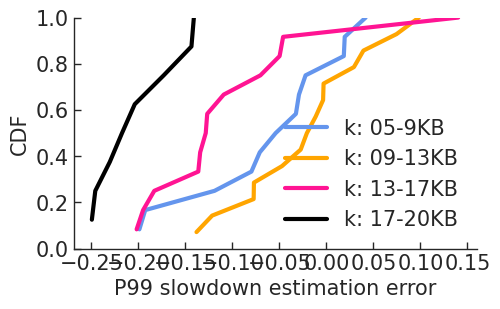

In [36]:

traffic_dict=defaultdict(list)
n_events_dict=defaultdict(list)
for mix_id in range(len(mixes)):
    if mask[mix_id]==False:
        continue
    mix=mixes[mix_id]
    cc=mix['cc']
    if mix["cc"]=="timely" and float(mix["param_1"])>60: continue
    if mix["cc"]!="dctcp": continue
    val_key=dctcp_k_dict[(mix["param_1"]-5)//4]
    lines_pkt_dropping=0
    with open(f"../data/{mix_id}/ns3-config/1/output.txt", 'r') as file:
        for line in file:
            if "Headroom full" in line:
                lines_pkt_dropping+=1
    lines_pfc=[1]
    with open(f"../data/{mix_id}/ns3-config/1/pfc_topology_flows_{cc_dict[cc]}.txt", 'r') as file:
        lines_pfc = file.readlines()
        
    traffic_dict[val_key].append(mix_id)
    n_events_dict[val_key].append([lines_pkt_dropping,len(lines_pfc)])
traffic_dict = dict(sorted(traffic_dict.items()))
n_events_dict = dict(sorted(n_events_dict.items()))

error_abs=[]
for i in range(1,len(res)):
    error_abs.append(np.abs(res[i]-res[0])/res[0])
plot_data=[np.array([error_abs[0][i] for i in traffic_dict[key]]) for key in traffic_dict]
plot_cdf(plot_data,None,list(traffic_dict.keys()),'Error of p99 slowdown',legend_font=15,group_size=len(traffic_dict),loc=4,rotate_xaxis=False)
print("median error: ", [np.median(plot_data[i]) for i in range(len(plot_data))])
print("90% error: ", [np.percentile(plot_data[i],90) for i in range(len(plot_data))])
print("max error: ", [np.max(plot_data[i]) for i in range(len(plot_data))])

plot_data=[np.array([x[0] for x in n_events_dict[key]])  for key in n_events_dict]
plot_cdf(plot_data,None,list(n_events_dict.keys()),'# of packet dropping',legend_font=15,group_size=len(n_events_dict),loc=4,rotate_xaxis=False,log_switch=True)

plot_data=[np.array([x[1] for x in n_events_dict[key]])  for key in n_events_dict]
plot_cdf(plot_data,None,list(n_events_dict.keys()),'# of PFC event',legend_font=15,group_size=len(n_events_dict),loc=4,rotate_xaxis=False,log_switch=True)

error_real=[]
for i in range(1,len(res)):
    error_real.append((res[i]-res[0])/res[0])
plot_data=[np.array([error_real[0][i] for i in traffic_dict[key]]) for key in traffic_dict]
plot_cdf(plot_data,None,list(traffic_dict.keys()),'P99 slowdown estimation error',legend_font=15,group_size=len(traffic_dict),loc=4,rotate_xaxis=False)

/tmp/ipykernel_1333236/762503571.py:29: RuntimeWarning: invalid value encountered in divide
  error_abs.append(np.abs(res[i]-res[0])/res[0])


median error:  [0.15390936347509077, 0.059681364551944435, 0.1385242107938142, 0.1535708809259572]
90% error:  [0.20878614655626657, 0.22560982156733367, 0.35025699382592035, 0.36026514840425744]
max error:  [0.21488445045455645, 0.2780151073405194, 0.6132301038723622, 0.4803326018714933]


/tmp/ipykernel_1333236/762503571.py:44: RuntimeWarning: invalid value encountered in divide
  error_real.append((res[i]-res[0])/res[0])


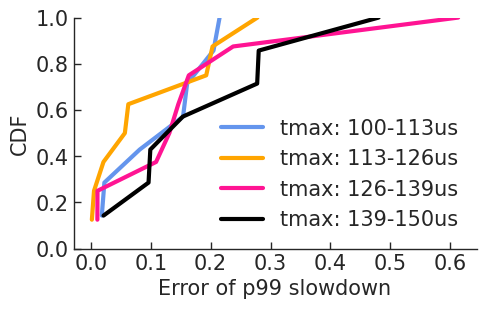

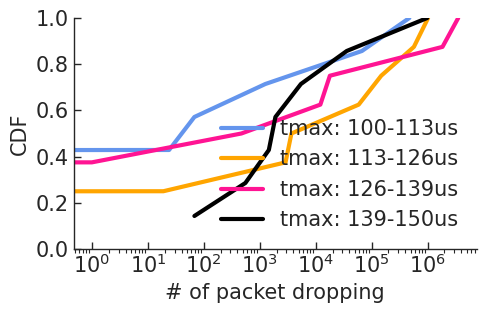

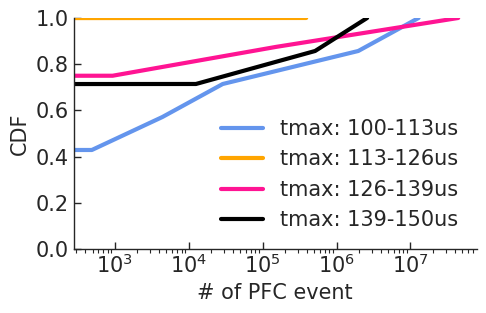

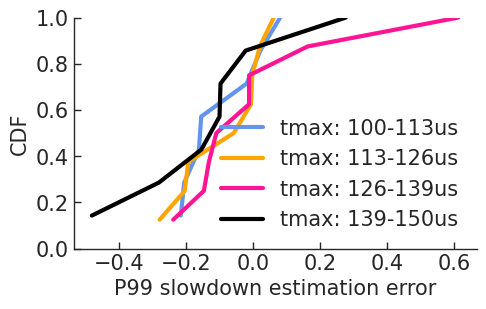

In [47]:

traffic_dict=defaultdict(list)
n_events_dict=defaultdict(list)
for mix_id in range(len(mixes)):
    if mask[mix_id]==False:
        continue
    mix=mixes[mix_id]
    cc=mix['cc']
    if mix["cc"]=="timely" and float(mix["param_1"])>60: continue
    if mix["cc"]!="timely": continue
    # val_key=timely_tmin_dict[(mix["param_1"]-40)//5]
    val_key=timely_tmax_dict[(mix["param_2"]-100)//13]
    # val_key=timely_tmin_dict[(mix["param_1"]-40)//15]+'_'+timely_tmax_dict[(mix["param_2"]-100)//25]
    lines_pkt_dropping=0
    with open(f"../data/{mix_id}/ns3-config/1/output.txt", 'r') as file:
        for line in file:
            if "Headroom full" in line:
                lines_pkt_dropping+=1
    lines_pfc=[1]
    with open(f"../data/{mix_id}/ns3-config/1/pfc_topology_flows_{cc_dict[cc]}.txt", 'r') as file:
        lines_pfc = file.readlines()
        
    traffic_dict[val_key].append(mix_id)
    n_events_dict[val_key].append([lines_pkt_dropping,len(lines_pfc)])
traffic_dict = dict(sorted(traffic_dict.items()))
n_events_dict = dict(sorted(n_events_dict.items()))

error_abs=[]
for i in range(1,len(res)):
    error_abs.append(np.abs(res[i]-res[0])/res[0])
plot_data=[np.array([error_abs[0][i] for i in traffic_dict[key]]) for key in traffic_dict]
plot_cdf(plot_data,None,list(traffic_dict.keys()),'Error of p99 slowdown',legend_font=15,group_size=len(traffic_dict),loc=4,rotate_xaxis=False)
print("median error: ", [np.median(plot_data[i]) for i in range(len(plot_data))])
print("90% error: ", [np.percentile(plot_data[i],90) for i in range(len(plot_data))])
print("max error: ", [np.max(plot_data[i]) for i in range(len(plot_data))])

plot_data=[np.array([x[0] for x in n_events_dict[key]])  for key in n_events_dict]
plot_cdf(plot_data,None,list(n_events_dict.keys()),'# of packet dropping',legend_font=15,group_size=len(n_events_dict),loc=4,rotate_xaxis=False,log_switch=True)

plot_data=[np.array([x[1] for x in n_events_dict[key]])  for key in n_events_dict]
plot_cdf(plot_data,None,list(n_events_dict.keys()),'# of PFC event',legend_font=15,group_size=len(n_events_dict),loc=4,rotate_xaxis=False,log_switch=True)

error_real=[]
for i in range(1,len(res)):
    error_real.append((res[i]-res[0])/res[0])
plot_data=[np.array([error_real[0][i] for i in traffic_dict[key]]) for key in traffic_dict]
plot_cdf(plot_data,None,list(traffic_dict.keys()),'P99 slowdown estimation error',legend_font=15,group_size=len(traffic_dict),loc=4,rotate_xaxis=False)

/tmp/ipykernel_1333236/768098288.py:30: RuntimeWarning: invalid value encountered in divide
  error_abs.append(np.abs(res[i]-res[0])/res[0])
/tmp/ipykernel_1333236/768098288.py:45: RuntimeWarning: invalid value encountered in divide
  error_real.append((res[i]-res[0])/res[0])


median error:  [0.02259945340234904, 0.030773174096502896, 0.05526649112672708, 0.06390670161601361]
90% error:  [0.20942771288916998, 0.20735677110608244, 0.12991328212789913, 0.1573515018628079]
max error:  [0.238475199117817, 0.26409362338038966, 0.1648157996763163, 0.2305513758120872]


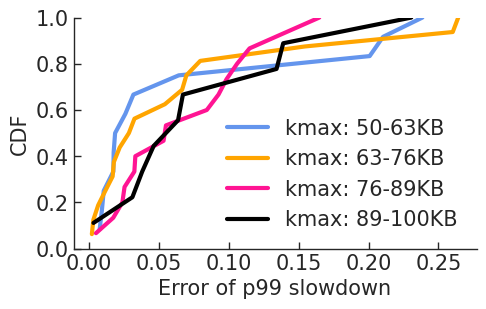

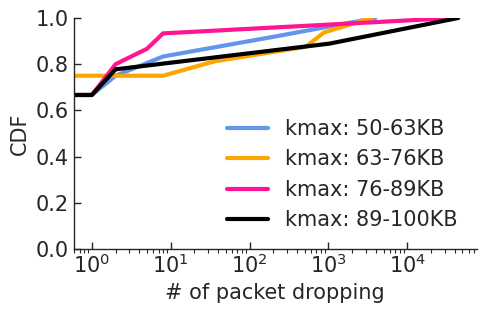

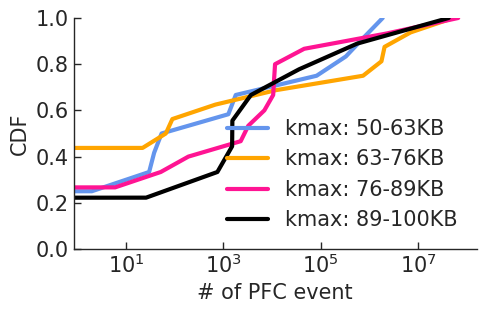

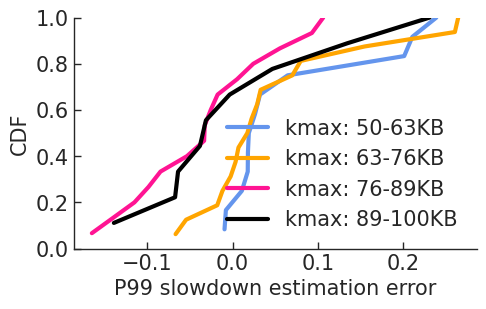

In [48]:

traffic_dict=defaultdict(list)
n_events_dict=defaultdict(list)
for mix_id in range(len(mixes)):
    if mask[mix_id]==False:
        continue
    mix=mixes[mix_id]
    cc=mix['cc']
    if mix["cc"]=="timely" and float(mix["param_1"])>60: continue
    if mix["cc"]!="dcqcn": continue
    # val_key=dcqcn_kmin_dict[(mix["param_1"]-20)//8]
    val_key=dcqcn_kmax_dict[(mix["param_2"]-50)//13]
    
    # traffic_dict[traffic_mat+'_'+oversub].append(mix_id)
    lines_pkt_dropping=0
    with open(f"../data/{mix_id}/ns3-config/1/output.txt", 'r') as file:
        for line in file:
            if "Headroom full" in line:
                lines_pkt_dropping+=1
    lines_pfc=[1]
    with open(f"../data/{mix_id}/ns3-config/1/pfc_topology_flows_{cc_dict[cc]}.txt", 'r') as file:
        lines_pfc = file.readlines()
        
    traffic_dict[val_key].append(mix_id)
    n_events_dict[val_key].append([lines_pkt_dropping,len(lines_pfc)])
traffic_dict = dict(sorted(traffic_dict.items()))
n_events_dict = dict(sorted(n_events_dict.items()))

error_abs=[]
for i in range(1,len(res)):
    error_abs.append(np.abs(res[i]-res[0])/res[0])
plot_data=[np.array([error_abs[0][i] for i in traffic_dict[key]]) for key in traffic_dict]
plot_cdf(plot_data,None,list(traffic_dict.keys()),'Error of p99 slowdown',legend_font=15,group_size=len(traffic_dict),loc=4,rotate_xaxis=False)
print("median error: ", [np.median(plot_data[i]) for i in range(len(plot_data))])
print("90% error: ", [np.percentile(plot_data[i],90) for i in range(len(plot_data))])
print("max error: ", [np.max(plot_data[i]) for i in range(len(plot_data))])

plot_data=[np.array([x[0] for x in n_events_dict[key]])  for key in n_events_dict]
plot_cdf(plot_data,None,list(n_events_dict.keys()),'# of packet dropping',legend_font=15,group_size=len(n_events_dict),loc=4,rotate_xaxis=False,log_switch=True)

plot_data=[np.array([x[1] for x in n_events_dict[key]])  for key in n_events_dict]
plot_cdf(plot_data,None,list(n_events_dict.keys()),'# of PFC event',legend_font=15,group_size=len(n_events_dict),loc=4,rotate_xaxis=False,log_switch=True)

error_real=[]
for i in range(1,len(res)):
    error_real.append((res[i]-res[0])/res[0])
plot_data=[np.array([error_real[0][i] for i in traffic_dict[key]]) for key in traffic_dict]
plot_cdf(plot_data,None,list(traffic_dict.keys()),'P99 slowdown estimation error',legend_font=15,group_size=len(traffic_dict),loc=4,rotate_xaxis=False)

/tmp/ipykernel_1333236/1188370030.py:32: RuntimeWarning: invalid value encountered in divide
  error_abs.append(np.abs(res[i]-res[0])/res[0])


median error:  [0.04915503906669093, 0.10706752750494786, 0.06524858544371087, 0.08443616599673578]
90% error:  [0.11037813927161719, 0.20432887588837872, 0.12078810188996231, 0.21364051676770862]
max error:  [0.19307121982761294, 0.3600468246206708, 0.17096582424680748, 0.3455820225285228]


/tmp/ipykernel_1333236/1188370030.py:47: RuntimeWarning: invalid value encountered in divide
  error_real.append((res[i]-res[0])/res[0])


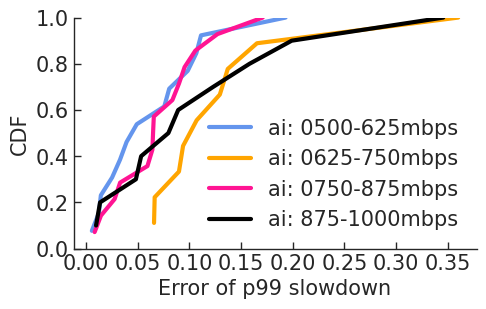

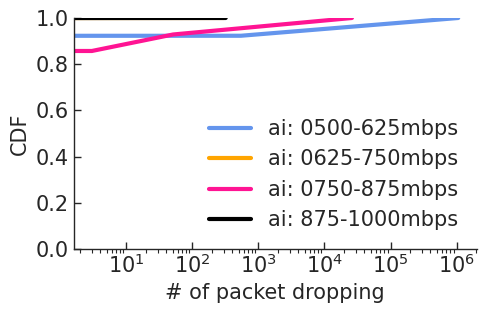

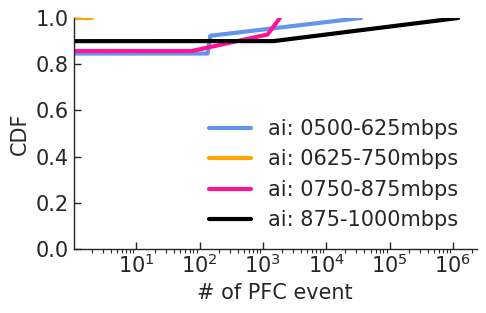

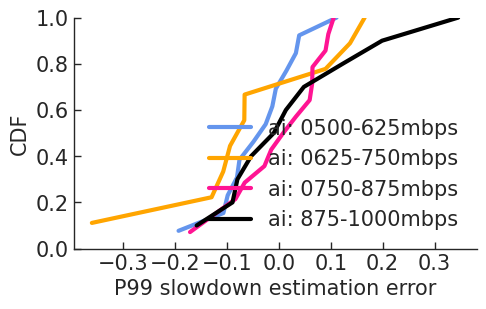

In [51]:

traffic_dict=defaultdict(list)
n_events_dict=defaultdict(list)
for mix_id in range(len(mixes)):
    if mask[mix_id]==False:
        continue
    mix=mixes[mix_id]
    cc=mix['cc']
    if mix["cc"]=="timely" and float(mix["param_1"])>60: continue
    if mix["cc"]!="hp": continue
    # val_key=hp_ita_dict[(mix["param_1"]-70)//7]
    val_key=hp_ai_dict[(mix["param_2"]-50)//13]
    
    # val_key=bfsz_dict[(mix["bfsz"]-15)//5]+"_"+window_dict[(mix["window"]-10000)//10000]
    
    # traffic_dict[traffic_mat+'_'+oversub].append(mix_id)
    lines_pkt_dropping=0
    with open(f"../data/{mix_id}/ns3-config/1/output.txt", 'r') as file:
        for line in file:
            if "Headroom full" in line:
                lines_pkt_dropping+=1
    lines_pfc=[1]
    with open(f"../data/{mix_id}/ns3-config/1/pfc_topology_flows_{cc_dict[cc]}.txt", 'r') as file:
        lines_pfc = file.readlines()
        
    traffic_dict[val_key].append(mix_id)
    n_events_dict[val_key].append([lines_pkt_dropping,len(lines_pfc)])
traffic_dict = dict(sorted(traffic_dict.items()))
n_events_dict = dict(sorted(n_events_dict.items()))

error_abs=[]
for i in range(1,len(res)):
    error_abs.append(np.abs(res[i]-res[0])/res[0])
plot_data=[np.array([error_abs[0][i] for i in traffic_dict[key]]) for key in traffic_dict]
plot_cdf(plot_data,None,list(traffic_dict.keys()),'Error of p99 slowdown',legend_font=15,group_size=len(traffic_dict),loc=4,rotate_xaxis=False)
print("median error: ", [np.median(plot_data[i]) for i in range(len(plot_data))])
print("90% error: ", [np.percentile(plot_data[i],90) for i in range(len(plot_data))])
print("max error: ", [np.max(plot_data[i]) for i in range(len(plot_data))])

plot_data=[np.array([x[0] for x in n_events_dict[key]])  for key in n_events_dict]
plot_cdf(plot_data,None,list(n_events_dict.keys()),'# of packet dropping',legend_font=15,group_size=len(n_events_dict),loc=4,rotate_xaxis=False,log_switch=True)

plot_data=[np.array([x[1] for x in n_events_dict[key]])  for key in n_events_dict]
plot_cdf(plot_data,None,list(n_events_dict.keys()),'# of PFC event',legend_font=15,group_size=len(n_events_dict),loc=4,rotate_xaxis=False,log_switch=True)

error_real=[]
for i in range(1,len(res)):
    error_real.append((res[i]-res[0])/res[0])
plot_data=[np.array([error_real[0][i] for i in traffic_dict[key]]) for key in traffic_dict]
plot_cdf(plot_data,None,list(traffic_dict.keys()),'P99 slowdown estimation error',legend_font=15,group_size=len(traffic_dict),loc=4,rotate_xaxis=False)